## <center>  Project 4  Web Scraping + NLP </center>

In [4]:
import urllib
import pandas as pd
import numpy as np
from time import sleep
from bs4 import BeautifulSoup
import requests
from selenium import webdriver
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.cross_validation import train_test_split
from sklearn.tree import DecisionTreeClassifier 
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.metrics import accuracy_score
from sklearn import preprocessing
from collections import Counter
import matplotlib.pyplot as plt
%matplotlib inline

/Users/lucky/anaconda2/lib/python2.7/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In this Project, We will explore trending posts and comments on reddit. Reddit is a community-driven link-sharing site. Users submit links to articles, photos, and other content. Other users upvote the submissions they like, and downvote the ones they dislike. Users can comment on submissions, and even upvote or downvote other people's comments. Reddit consists of many smaller communities called subreddits where more focused communities can discuss niche posts. we will start by gathering the data using tools like webdriver, and with the help of BeautifulSoup we will read and save that data into lists.
We will start our initial analysis about the data by making one DataFrame from those lists, We will check for any missing values, If present we will be replacing it or getting rid of that particular row depending on quality and quantity of missing values. Next, We will convert the columns to numerical columns, here librarires HotEncoder, or labelEncoder will be used. Once we have our DataFrame ready to go, we will do Our Analysis. We will convert the Number of Comment columns (which is our y in this case) to binary column, we will check for the baseline. Then, We will create two subsets of our dataframes, One will contain values with the number of comments above the median and the other dataset will contain the values with the number of comments below the median. And we will check The Title name columns of those datasets, we will check the most occurring words, and try to understand what make one post to be popular than the other. Once, we have the better understanding of the words in the each sub-DataFrame We will use Sentiment Analysis library, like Vader, which can be used to identify the most positive and negative words in the DataFrame. Next, We will try to create a model which can predict by analyzing the name of the title if the particular post will have number of comments below median or above median. Here we will test different classifier models, like DecisionTreeClassifier, RandomForestClassifier, LogisticRegression etc. we will further try to improve our accuracy score with other gradientboosting algorithm such as: adaboost, Xgboost or GradientBoost.

### *__Web Scraping: __*

In [7]:
limit = 0
page = 'http://www.reddit.com'

#Below Lists will store our scraped data
titles = []
time_since = []
comments = []
subreddit = []

# j will be used in our function below to get rid of 25th element (Advertised title)
j = 0

#will keep track of loops
limit = 0

In [5]:
while limit <= 200:
    
   #------------------------------------------------------------------------# 
    driver = webdriver.Chrome(executable_path="./chromedriver/chromedriver")
    driver.get(page)
    html = driver.page_source
    soup = BeautifulSoup(html, 'lxml')
    sleep(10)
    
   # Above we are setting our webdriver, which is getting data from Reddit,
   # as html and converts it into lxml format for BeautfulSoup which we will
   # use below to extract data.
   #------------------------------------------------------------------------#
    
    
    # Below are scraping each Title from the page.
    for title in soup.find_all('p', {'class' : 'title' }):
        try:
            titles.append(title.text)
        
        except:
            print "Iteration :", limit, "Unsuccessfull attempt to Extract Title, BREAK!!!"
            titles.append('Error')
            break
    sleep(2)
    
    # Extracting Live-Timestamp and saving it in a list.
    for time in soup.find_all('time', {'class' : 'live-timestamp'}):
        try:
            time_since.append(time.text)
       
        except:
            print "Iteration :", limit, "Unsuccessfull attempt to Extract Time_since, BREAK!!!"
            time_since.append('Error')
            break
            
    sleep(2)
    
    # Extracing subreddit and saving in into a list.
    for x in soup.find_all('a', {'class' : 'subreddit hover may-blank'}):
        try:
            subreddit.append(x.text[2:])
    
        except:
            print "Iteration :", limit, "Unsuccessfull attempt to Extract Subreddit, BREAK!!!!"
            subreddit.append('Error')
            break
    
    
    sleep(2)
    
    # Scraping Comments
    for i in soup.find_all('li', {'class' : 'first'}):
        try:
            comments.append(i.text.split()[0])
        except:
            print "Iteration :", limit, "Unsuccessfull attempt to Extract Comment, BREAK!!!!"
            comments.append('Error')
            break
    
    # Finds next page and clicks on it and save the link into page.
    try:
        page = soup.find('span', {'class':'next-button'}).a['href']
    except:
        pass

    #-------------#
    del titles[j]  # Get rids of top title from each page, which is advertised title.
    j += 25
    #-------------#
    
    print("Length of List TITLES: ", len(titles))
    print("Length of Comments: ", len(comments)) #Printing length of each list to check 
    print("Length of Subreddit: ", len(subreddit))
    print("Length of time_since: ", len(time_since))
    
    driver.close()
    limit += 1


Below we are a dataframe with the data we scraped above and saving it as test.csv into project folder.

In [6]:

test = pd.DataFrame()
test['Comments'] = comments
test['Time_Since'] = time_since
test['Subreddit'] = subreddit
test['Titles'] = titles
test.to_csv('test.csv', encoding = 'utf-8')

#------------------------------Done with Web Scraping -------------------------------------------------------#

In [11]:
df = pd.DataFrame()

In [12]:
data = pd.read_csv('./data.csv')

In [13]:
data.head(2)

,Unnamed: 0,created_at,id,num_comments,subreddit,time_delta,time_now,title,upvotes
0,0,2018-01-22 16:36:35,470616764,1153,gifs,0 days 04:24:57.883078000,2018-01-22 21:01:32.883070,Finnish ski jumping team,86005
1,1,2018-01-22 16:37:28,470617063,238,pics,0 days 04:24:04.883093000,2018-01-22 21:01:32.883092,Super excited about motherhood,20336


In [14]:
print data.shape
print data.isnull().any().sum()

(5567, 9)
0


In [15]:
data.created_at.astype

<bound method Series.astype of 0       2018-01-22 16:36:35
1       2018-01-22 16:37:28
2       2018-01-22 16:50:12
3       2018-01-22 17:25:20
4       2018-01-22 15:41:56
5       2018-01-22 15:01:59
6       2018-01-22 15:35:00
7       2018-01-22 14:51:38
8       2018-01-22 15:08:03
9       2018-01-22 17:38:32
10      2018-01-22 15:14:57
11      2018-01-22 16:49:29
12      2018-01-22 15:25:06
13      2018-01-22 14:16:41
14      2018-01-22 14:17:39
15      2018-01-22 14:10:24
16      2018-01-22 15:38:09
17      2018-01-22 14:46:49
18      2018-01-22 13:55:39
19      2018-01-22 14:16:05
20      2018-01-22 15:39:41
21      2018-01-22 13:15:12
22      2018-01-22 13:52:23
23      2018-01-22 15:10:47
24      2018-01-22 13:13:34
25      2018-01-22 14:24:57
26      2018-01-22 16:39:12
27      2018-01-22 14:54:27
28      2018-01-22 14:25:11
29      2018-01-22 18:00:48
               ...         
5537    2018-01-22 17:50:01
5538    2018-01-22 19:15:30
5539    2018-01-22 11:55:41
5540    2018-01-2

We are only going to keep Commments, Time_since, Subreddit, Title and upvotes.
Few columns need little cleaning, Below we are going over each columns that needs cleaning, we are going manipulate it, to obtain maximum usage of that columns data.
-We are not going to include creation time and time_now, as time_delta represents the difference between those two, So no need to add those two columns.

In [16]:
df['Comments'] = data['num_comments']
df['Time_Since'] = data['time_delta'] # Represents time difference between creation and present(scraped time).
df['Subreddit'] = data['subreddit']
df['Titles'] = data['title']
df['upvotes'] = data['upvotes']
 

For our Time_since column we need to keep only first two integers, and get rid of string values.

In [17]:
# Converting time_Since to just int val hours.
def my_func(obj):
    obj = obj[7:9]
    obj = obj
    return obj

df.Time_Since = df.Time_Since.apply(my_func)

In [18]:
df.head(2)

,Comments,Time_Since,Subreddit,Titles,upvotes
0,1153,04,gifs,Finnish ski jumping team,86005
1,238,04,pics,Super excited about motherhood,20336


In [19]:
encoder = preprocessing.LabelEncoder()
df.Subreddit = encoder.fit_transform(df.Subreddit)


In [20]:
df.head()

,Comments,Time_Since,Subreddit,Titles,upvotes
0,1153,04,1144,Finnish ski jumping team,86005
1,238,04,1409,Super excited about motherhood,20336
2,844,04,1112,Messing with the new guy.,17611
3,380,03,1531,NASA cancels and postpones all of their public...,11178
4,430,05,1579,New Bill Would Stop States From Banning Broadb...,13467


In [21]:
median_comment = df.Comments.median()
def to_num(comments):
    if comments > median_comment:
        return 1
    else:
        return 0

df.Comments = df.Comments.apply(to_num)


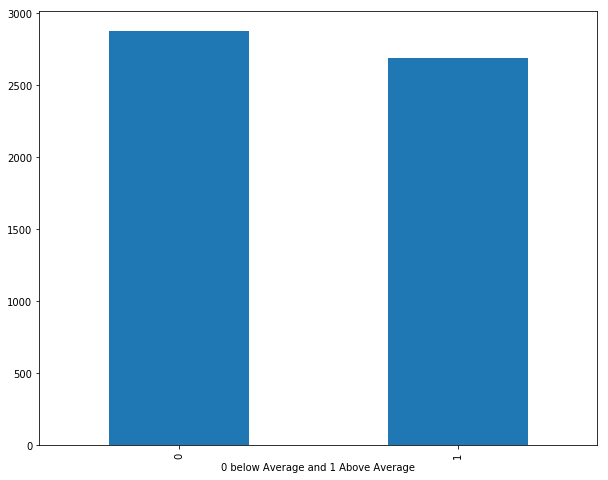

In [22]:
# Get plot of Value Counts
df.Comments.value_counts().plot(kind='bar', figsize=(10,8))
plt.xlabel('0 below Average and 1 Above Average');

In [23]:
df.head(2)

,Comments,Time_Since,Subreddit,Titles,upvotes
0,1,04,1144,Finnish ski jumping team,86005
1,1,04,1409,Super excited about motherhood,20336


In [24]:
below_median = df[df['Comments'] == 0]
above_median = df[df['Comments'] == 1]

In [25]:
print below_median.shape
print above_median.shape  #Almost 50%

(2876, 5)
(2691, 5)


## <center>  Most Occurred words in </center>

## <center>_Posts with Number of Comments above Median <br> vs. <br> Number of Comments Below Median.</center>_

In [157]:
# We can use the TfidfVectorizer to find ngrams for us
vect = TfidfVectorizer(ngram_range=(2,3), stop_words='english', lowercase= True)

summaries = "".join(below_median['Titles'])
ngrams_summaries = vect.build_analyzer()(summaries)
new_df = pd.DataFrame(Counter(ngrams_summaries).most_common(10), columns = ['Top_Words', 'Times_Occurred'])

In [158]:
new_df

,Top_Words,Times_Occurred
0,fuck sony,10
1,fuck sony fuck,8
2,sony fuck sony,8
3,sony fuck,8
4,year old,7
5,super bowl,7
6,alexis sanchez,6
7,women march,5
8,ball fighterz,5
9,years ago,5


Above we list shows Most occurred words in Titles which has number of comments below the Median. On any website with user generated content, trolls will appear. The truth about the internet is that offensive languages are unavoidable. Its looks like users are better off ignoring the posts whose title contain one of those words showed in the lists above. Users see these as trolls and will just ignore these kind of posts.


In [159]:
vect = TfidfVectorizer(ngram_range=(2,4), stop_words='english')

summaries = "".join(above_median['Titles'])
ngrams_summaries = vect.build_analyzer()(summaries)

Counter(ngrams_summaries).most_common(10)

[(u'years ago', 13),
 (u'super bowl', 13),
 (u'year old', 9),
 (u'alexis sanchez', 8),
 (u'looks like', 7),
 (u'government shutdown', 6),
 (u'supreme court', 6),
 (u'oh boy', 6),
 (u'ago today', 6),
 (u'years ago today', 5)]

It looks like Posts with neutral or Positive words in title, attracted more Users and encouraged them to comment more, which results in more number of comments, On the other hand as seen above Posts with very offensive language had number of comments below median.

### Below we will find the top most negative and Positve features by VADER score.


In [83]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
analyzer = SentimentIntensityAnalyzer()

In [87]:
df['vader_neg'] = 0
df['vader_pos'] = 0
df['vader_neu'] = 0
df['vader_compound'] = 0
for i, q in enumerate(df.Titles.values):
    vs = analyzer.polarity_scores(q)
    df.iloc[i, -4] = vs['neg']
    df.iloc[i, -3] = vs['pos']
    df.iloc[i, -2] = vs['neu']
    df.iloc[i, -1] = vs['compound']

## Top Negative words

In [88]:
df.sort_values('vader_neg', ascending=False, inplace=True)
for i in range(10):
    print df.Titles.values[i]


o shit
stolen
Sneaky
Fail
RIOT
Shit
Evil
Damn.
The Death Penalty
real shit :(


## Top Positive words

In [89]:
df.sort_values('vader_pos', ascending = False, inplace=True)
for i in range(10):
    print df.Titles.values[i]

Delicious.
Beauty
Congratulations!
True
Joke.
Lol
Well well
Hooray!
C L E M Approves
lol


We did our intial analysis, we pretty much got the idia of what do all the titles with number of comments above the average have in common. Now lets just check the baseline, and we will try to create a model intelligent enought to predict if given titles name, to predict if that specific title will have number of comments below or Above average. We will test multiple modelsl, and we will choose one with them most accuracy score.

In [161]:
max(df.Comments.value_counts(normalize=True)) # Baseline


0.51661577151068794

### Lets check our models performance solely by sentiment features.

In [162]:

X = df[['vader_neg','vader_pos','vader_neu','vader_compound']]
y = df.Comments

Xs = preprocessing.StandardScaler().fit_transform(X)
cv = StratifiedKFold(n_splits=10, random_state=42)  
scores = cross_val_score(LogisticRegression(), Xs, y, cv=cv)
print scores
print np.mean(scores)

[ 0.52150538  0.52603232  0.52064632  0.52962298  0.51705566  0.51705566
  0.50539568  0.51258993  0.57374101  0.51618705]
0.52398319718


Barely above the baseline!

In [163]:
tfv = TfidfVectorizer(ngram_range=(2,4),max_features=7000, lowercase = True, stop_words = 'english', )
tfv_matrix = tfv.fit_transform(df.Titles).todense()

In [164]:
tfv_matrix.shape

(5567, 7000)

In [166]:
title_words = pd.DataFrame(tfv_matrix, columns = tfv.get_feature_names())


In [167]:
df = pd.concat([df, title_words], axis = 1)

In [168]:
print df.shape

(5567, 7009)


In [170]:
df.drop('Titles', axis = 1, inplace = True)

In [171]:
df.head(2)

,Comments,Time_Since,Subreddit,upvotes,vader_neg,vader_pos,vader_neu,vader_compound,00 30,00 gmt,...,york evidence support,york evidence support theory,yosemite national,yosemite national park,yosemite national park oc,youtube channel,youtube video,zelda cube,zoe van,zoe van dijk
0,1,04,1144,86005,0.0,0.000,1.000,0.000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,04,1409,20336,0.0,0.759,0.241,0.743,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Machine learning:

In [174]:
X = df.drop('Comments', axis = 1)
y = df.Comments

### Using DecisionTreeClassifier

In [180]:
cv = StratifiedKFold(n_splits=10, random_state=42)  
dt = DecisionTreeClassifier(max_depth= 10)
scores = cross_val_score(dt, X, y, cv=cv)
print scores
print np.mean(scores)

[ 0.60394265  0.76481149  0.66965889  0.62118492  0.64452424  0.62298025
  0.67266187  0.68884892  0.69064748  0.70323741]
0.668249812034


## Using RandomForestClassifier

In [183]:
cv = StratifiedKFold(n_splits=10, random_state=42)  
rfc = RandomForestClassifier(n_estimators= 200)

scores = cross_val_score(dt, X, y, cv=cv)
print scores
print np.mean(scores)


[ 0.60573477  0.76481149  0.67145422  0.62298025  0.6481149   0.62118492
  0.67086331  0.67985612  0.68705036  0.70503597]
0.667708630339


In [196]:
grad = GradientBoostingClassifier()
cross_val_score(grad, X, y, cv=cv).mean()

0.70884594577190507

With GradientBoostingClassifier we Improved our accuracy score from .66 to .70 which is approx. 20% more than the baseline.